<a href="https://colab.research.google.com/github/sanchimanchanda/Import-EDA-regression-classification/blob/main/assignment_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Assignment Notebook

Loads datasets, performs EDA, linear regression, Bayesian logistic (Laplace approx), and SVM.

Date: 24-09-2025
Institution: SRM Institute of Science and Technology, Kattankulathur


In [ ]:
# Install any missing packages if running in a fresh environment (uncomment if needed)
# !pip install scipy python-docx nbformat seaborn


In [ ]:
from sklearn import datasets, model_selection, linear_model, svm, metrics, preprocessing
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.special import expit
from scipy.optimize import minimize


In [ ]:
# Load datasets
diabetes = datasets.load_diabetes(as_frame=True)
diabetes_df = diabetes.frame.copy(); diabetes_df['target'] = diabetes.target
cancer = datasets.load_breast_cancer(as_frame=True)
cancer_df = cancer.frame.copy(); cancer_df['target'] = cancer.target
print('Diabetes shape:', diabetes_df.shape)
print('Breast cancer shape:', cancer_df.shape)


Diabetes shape: (442, 11)
Breast cancer shape: (569, 31)


In [ ]:
# Summary statistics
display(diabetes_df.head())
display(diabetes_df.describe())


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


R2: 0.4526027629719195
MSE: 2900.1936284934814


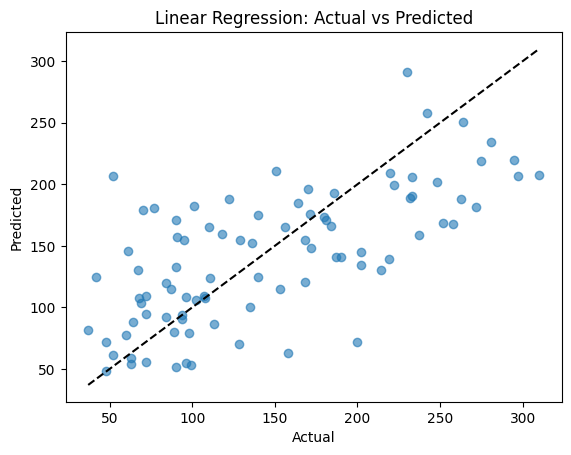

In [ ]:
# Linear regression (Diabetes)
X = diabetes_df.drop(columns=['target']); y = diabetes_df['target']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
lr = linear_model.LinearRegression(); lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('R2:', metrics.r2_score(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
plt.scatter(y_test, y_pred, alpha=0.6); plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'k--'); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Linear Regression: Actual vs Predicted'); plt.show()


In [ ]:
# Bayesian logistic regression - Laplace approx (Breast cancer)
Xc = cancer_df.drop(columns=['target']).values; yc = cancer_df['target'].values
scaler = preprocessing.StandardScaler(); Xc_std = scaler.fit_transform(Xc)
X_design = np.hstack([np.ones((Xc_std.shape[0],1)), Xc_std])
lambda_prior = 1.0
def neg_log_posterior(w, X, y, lambda_prior):
    z = X.dot(w); loglik = np.sum(y*z - np.log1p(np.exp(z))); prior = -0.5 * lambda_prior * np.sum(w[1:]**2)
    return - (loglik + prior)
def grad_neg_log_posterior(w, X, y, lambda_prior):
    p = expit(X.dot(w)); grad = X.T.dot(y - p); grad_prior = np.concatenate([[0.0], -lambda_prior * w[1:]])
    return - (grad + grad_prior)

w0 = np.zeros(X_design.shape[1])
res = minimize(neg_log_posterior, w0, args=(X_design, yc, lambda_prior), jac=grad_neg_log_posterior, method='Newton-CG')
w_map = res.x
print('MAP coefficients (first 10):', w_map[:10])


MAP coefficients (first 10): [ 0.21450272 -0.36309252 -0.38767544 -0.35106211 -0.43560979 -0.16183109
  0.56265404 -0.85991709 -0.96228025  0.07620899]


In [ ]:
# SVM classification
Xc_features = cancer_df.drop(columns=['target']); y_c = cancer_df['target']
X_train_svc, X_test_svc, y_train_svc, y_test_svc = model_selection.train_test_split(Xc_features, y_c, test_size=0.2, random_state=42)
scaler2 = preprocessing.StandardScaler(); X_train_svc_std = scaler2.fit_transform(X_train_svc); X_test_svc_std = scaler2.transform(X_test_svc)
svc = svm.SVC(kernel='rbf', probability=True); svc.fit(X_train_svc_std, y_train_svc)
y_prob_svc = svc.predict_proba(X_test_svc_std)[:,1]; y_pred_svc = svc.predict(X_test_svc_std)
print('SVC AUC:', metrics.roc_auc_score(y_test_svc, y_prob_svc))
print('SVC Accuracy:', metrics.accuracy_score(y_test_svc, y_pred_svc))


SVC AUC: 0.99737962659679
SVC Accuracy: 0.9824561403508771
